# Group Details

## Group Name: Group 08

### Student 1: Jasper Linders

### Student 2: Alexander Liu

### Student 3: Sjoerd van Straten

# Loading Data and Preliminaries

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [61]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [62]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_array('/content/drive/MyDrive/Assignment 2/data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array('/content/drive/MyDrive/Assignment 2/data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


In [63]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""
example = load_array('/content/drive/MyDrive/Assignment 2/data/task 1/train/trajectory_2.npz', task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (9, 5)
shape of terminal state (to be predicted by model): (9, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -6.368508338132521


# Data Handling and Preprocessing

First, let's import the data and make variables for the train and test data.

In [64]:
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset

class ImportData(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = sorted(os.listdir(folder_path))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        data, label = load_array(file_path, task='task 1')
        return data, label

# Create an instance of the custom dataset class with the folder path
train_import = ImportData('/content/drive/MyDrive/Assignment 2/data/task 1/train/')
test_import = ImportData('/content/drive/MyDrive/Assignment 2/data/task 1/test/')

X_train_import = []
y_train_import = []
X_test_import = []
y_test_import = []

# Iterate through the train_dataset to extract data and labels
for data, label in train_import:
    X_train_import.append(data)
    y_train_import.append(label)

for data, label in test_import:
    X_test_import.append(data)
    y_test_import.append(label)

max_length = 9

# Pad the data samples with zeros to have the same shape
X_train_padded = []
for data in X_train_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_train_padded.append(padded_data)

y_train_padded = []
for label in y_train_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_train_padded.append(padded_label)

X_test_padded = []
for data in X_test_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_test_padded.append(padded_data)

y_test_padded = []
for label in y_test_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_test_padded.append(padded_label)

# Convert the padded data and labels to tensors
X_train_first = torch.tensor(np.array(X_train_padded))
y_train_first = torch.tensor(np.array(y_train_padded))

X_train = X_train_first[:700]
y_train = y_train_first[:700]
X_val = X_train_first[700:900]
y_val = y_train_first[700:900]
X_test = torch.tensor(np.array(X_test_padded))
y_test = torch.tensor(np.array(y_test_padded))


# Print the shape of X_train and the first label in y_train
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

#Make datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

#Make dataloader
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

X_train shape:  torch.Size([700, 9, 5])
y_train shape:  torch.Size([700, 9, 2])
X_val shape:  torch.Size([200, 9, 5])
y_val shape:  torch.Size([200, 9, 2])
X_test shape:  torch.Size([100, 9, 5])
y_test shape:  torch.Size([100, 9, 2])


# Model Implementation

In [65]:
def compute_sum_euclidean(output, target):
    distance = 0
    output = output.detach().numpy()
    target = target.numpy()
    for i in range(len(target)):
        # print(output[i], target[i])
        dist = np.linalg.norm(output[i] - target[i])
        # print(dist)
        distance += dist
    return distance

In [66]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=5, hidden_size=64, num_layers=5, batch_first=True)
        self.linear = nn.Linear(64, 2)

    def forward(self, x):
        x, _ = self.lstm(x)
        # print(_[1].shape)
        x = self.linear(x)
        return x

# Model Training

Epoch 1/200, Training Loss: 12.97231744170189, Summed Distance: 14.453616760798862
Epoch 2/200, Training Loss: 7.392170253694058, Summed Distance: 10.458172845499856
Epoch 3/200, Training Loss: 5.7180246674163, Summed Distance: 9.07509381702968
Epoch 4/200, Training Loss: 5.38295581047024, Summed Distance: 8.76730990443911
Epoch 5/200, Training Loss: 5.121699065310614, Summed Distance: 8.52837441103799
Epoch 6/200, Training Loss: 4.956773063625608, Summed Distance: 8.377119864225387
Epoch 7/200, Training Loss: 4.778196995194469, Summed Distance: 8.209387710264751
Epoch 8/200, Training Loss: 4.578410094593252, Summed Distance: 8.0151059789317
Epoch 9/200, Training Loss: 4.379926004069192, Summed Distance: 7.817261485712868
Epoch 10/200, Training Loss: 4.24991140508226, Summed Distance: 7.71104114992278
Epoch 11/200, Training Loss: 4.076122419919287, Summed Distance: 7.521297940867288
Epoch 12/200, Training Loss: 3.9372924070273125, Summed Distance: 7.3792115914821625
Epoch 13/200, Train

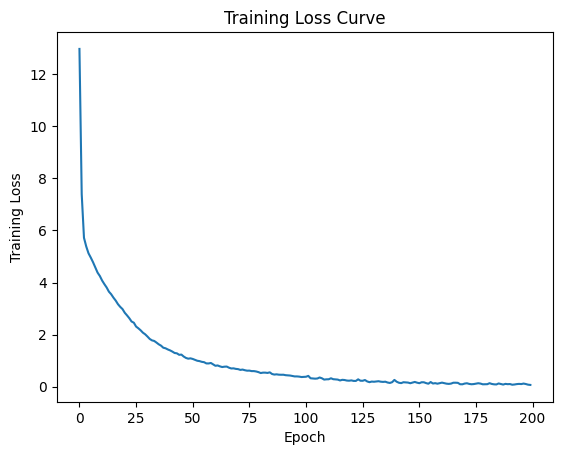

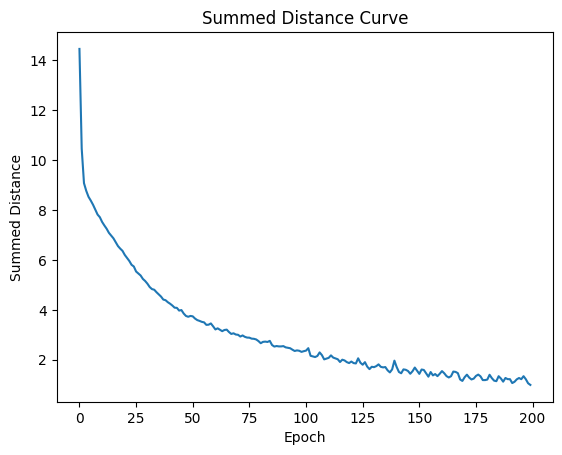

In [67]:
import torch.optim as optim

# Instantiate the MLP model
model = LSTM()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the number of epochs
num_epochs = 200

losses = []
distances = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()
    running_loss = 0.0
    dist = []
    num_objects = 9
    output_dim = 2

    # Iterate over the batches in the training data loader
    for inputs, labels in train_dataloader:
        # Convert input and label tensors to the same data type as model weights
        inputs = inputs.float()
        labels = labels.float()

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)
        distance = compute_sum_euclidean(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        running_loss += loss.item()
        dist.append(distance)

    # Calculate average loss and distance for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    epoch_distance = np.mean(dist)

    # Append to the lists
    losses.append(epoch_loss)
    distances.append(epoch_distance)

    # Print the training loss for each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_loss}, Summed Distance: {epoch_distance}")

# Plotting the training loss curve
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Curve')
plt.show()

# Plotting the summed distance curve
plt.figure()
plt.plot(distances)
plt.xlabel('Epoch')
plt.ylabel('Summed Distance')
plt.title('Summed Distance Curve')
plt.show()


In [80]:
torch.save(model.state_dict(), 'model_v1.pth')

# Evaluation

In [81]:
# After training, you can evaluate the model on the validation or test set
# Set the model to evaluation mode
model.load_state_dict(torch.load('model_v1.pth'))
model.eval()

# Initialize variables for evaluation
total_loss = 0
total_samples = 0
total_distance = 0

# Disable gradient calculation to save memory and computation
with torch.no_grad():
    # Iterate over the batches in the validation data loader
    for inputs, labels in val_dataloader:
        # Convert input tensor to the same data type as model weights
        inputs = inputs.float()

        # Forward pass
        outputs = model(inputs)

        # Convert labels tensor to the same data type as model outputs
        labels = labels.float()

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Update the total loss and number of samples
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        # Calculate the summed distance
        distance = compute_sum_euclidean(outputs, labels)
        total_distance += distance * inputs.size(0)

# Calculate the average validation loss and summed distance
avg_loss = total_loss / total_samples
avg_distance = total_distance / total_samples

print("Validation Loss: {:.4f}".format(avg_loss))
print("Average Summed Distance: {:.4f}".format(avg_distance))

Validation Loss: 5.5307
Average Summed Distance: 9.3151


In [79]:
# After training, you can evaluate the model on the validation or test set
# Set the model to evaluation mode
model.load_state_dict(torch.load('model_v1'))
model.eval()

# Initialize variables for evaluation
total_loss = 0
total_samples = 0
total_distance = 0

# Disable gradient calculation to save memory and computation
with torch.no_grad():
    # Iterate over the batches in the validation data loader
    for inputs, labels in test_dataloader:
        # Convert input tensor to the same data type as model weights
        inputs = inputs.float()

        # Forward pass
        outputs = model(inputs)

        # Convert labels tensor to the same data type as model outputs
        labels = labels.float()

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Update the total loss and number of samples
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        # Calculate the summed distance
        distance = compute_sum_euclidean(outputs, labels)
        total_distance += distance * inputs.size(0)

# Calculate the average validation loss and summed distance
avg_loss = total_loss / total_samples
avg_distance = total_distance / total_samples

print("Test Loss: {:.4f}".format(avg_loss))
print("Average Summed Distance: {:.4f}".format(avg_distance))

Test Loss: 4.3910
Average Summed Distance: 8.5017


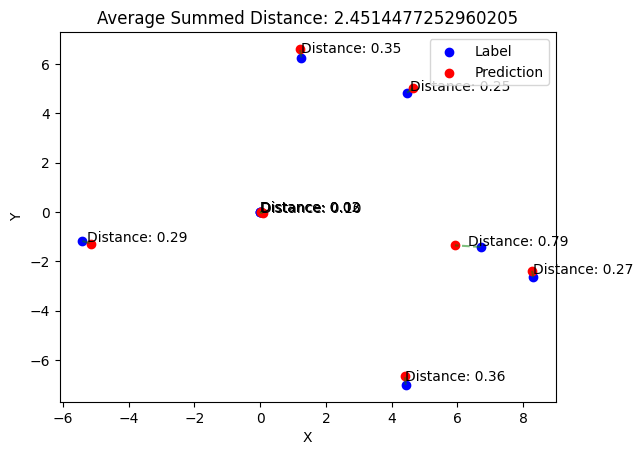

In [85]:
# Select a system from the train dataset
index = 12 # Replace with the index of the system you want to select

# Get the input and label for the selected system
input_sample = X_train[index]
label_sample = y_train[index]

# Convert the input and label to tensors
input_tensor = input_sample.clone().detach().unsqueeze(0).float() # Add an extra dimension for batch size
label_tensor = label_sample.clone().detach().unsqueeze(0).float()  # Add an extra dimension for batch size

# Pass the input tensor through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output_tensor = model(input_tensor)

# Convert the tensors to numpy arrays
input_array = input_tensor.numpy()
label_array = label_tensor.numpy()
output_array = output_tensor.numpy()

# Extract x and y coordinates from the arrays
pred_x, pred_y = output_array[0, :, 0], output_array[0, :, 1]
label_x, label_y = label_array[0, :, 0], label_array[0, :, 1]

# Calculate the distances between the points
distances = np.sqrt((pred_x - label_x)**2 + (pred_y - label_y)**2)

# Calculate the average distance
summed = np.sum(distances)

import matplotlib.pyplot as plt

# Plotting the points and lines
plt.figure()
plt.scatter(label_x, label_y, color='blue', label='Label')
plt.scatter(pred_x, pred_y, color='red', label='Prediction')
for i in range(len(distances)):
    plt.plot([label_x[i], pred_x[i]], [label_y[i], pred_y[i]], color='green', linestyle='--', alpha=0.5)
    plt.annotate(f"Distance: {distances[i]:.2f}", ((label_x[i] + pred_x[i]) / 2, (label_y[i] + pred_y[i]) / 2), color='black')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f"Average Summed Distance: {np.mean(summed)}")
plt.legend()
plt.show()
